In [1]:
%cd /app

/app


In [2]:
import argparse
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import torch
torch.multiprocessing.set_start_method('spawn')

import jax
from lob.encoding import Vocab, Message_Tokenizer

from lob import inference_no_errcorr as inference
from lob.init_train import init_train_state, load_checkpoint, load_metadata, load_args_from_checkpoint

from lob import inference_no_errcorr as inference
import lob.encoding as encoding
import preproc as preproc

import jax.numpy as jnp
import numpy as np

from pathlib import Path
import os

import pandas as pd
import plotly.graph_objs as go
import yaml

from filtration_utils import summary_table, build_zero_padded_series, plot_midprice_series_with_insertions, prepare_volatility_filtered_series, plot_midprice_series_with_mean_std

2025-08-12 13:13:04.819111: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.41). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2025-08-12 13:13:08.094510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
experiment_name = 'exp_43_20250809_085521'  #      exp_24_20250805_101039_gen_buy_whole_55


CONFIG_PATH = f"/app/data_saved/{experiment_name}/used_config.yaml"

# Load YAML config
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Extract values
num_insertions      = config["num_insertions"]
num_coolings        = config["num_coolings"]
midprice_step_size  = config["midprice_step_size"]
hist_msgs           = config["n_messages"]
n_gen_msgs          = config["n_gen_msgs"]
Direction           = config["DIRECTION_i"]

print(f"Aggressive {'buy' if Direction == 0 else 'sell'}\n")
print(f'num_insertions: {num_insertions}')
print(f'num_coolings: {num_coolings}')
print(f'midprice_step_size: {midprice_step_size}')
print(f'hist_msgs: {hist_msgs}')
print(f'n_gen_msgs: {n_gen_msgs}')

Aggressive buy

num_insertions: 20
num_coolings: 30
midprice_step_size: 1
hist_msgs: 500
n_gen_msgs: 50


In [4]:
# order_volume = config["order_volume"]
# order_volume_ratio = config["order_volume_ratio"]
# use_relative_volume = config["use_relative_volume"]

# print(f'use_relative_volume: {use_relative_volume}')
# print(f'order_volume: {order_volume}')
# print(f'order_volume_ratio: {order_volume_ratio}')

# use_sample_file = config["use_sample_file"]
# sample_file_path = config["sample_file_path"]
# start_batch = config["start_batch"]
# end_batch = config["end_batch"]

# print(f'\nuse_sample_file: {use_sample_file}')
# print(f'sample_file_path: {sample_file_path}')
# print(f'start_batch: {start_batch}')
# print(f'end_batch: {end_batch}')

In [5]:
hist_steps = hist_msgs // midprice_step_size       # 500
gen_steps = n_gen_msgs // midprice_step_size     # 50
gen_block = gen_steps + 1                        # 51

merged = summary_table(experiment_name)
x, all_series = build_zero_padded_series(hist_msgs, n_gen_msgs, midprice_step_size, merged)

print(merged)

       id                                        merged_data
0      69  [898300, 898300, 898300, 898300, 898300, 89830...
1      97  [902800, 902800, 902800, 902800, 902800, 90280...
2     140  [905500, 905500, 905500, 905500, 905500, 90550...
3     220  [903700, 903700, 903700, 903700, 903700, 90370...
4     275  [907900, 907900, 907900, 907900, 907900, 90790...
..    ...                                                ...
163  6936  [890800, 890800, 890800, 890800, 890800, 89080...
164  6991  [890500, 890500, 890500, 890500, 890500, 89050...
165  7009  [890100, 890100, 890100, 890100, 890100, 89010...
166  7098  [888300, 888300, 888300, 888400, 888400, 88840...
167  7187  [886700, 886800, 886800, 886800, 886800, 88680...

[168 rows x 2 columns]


In [6]:
fig = plot_midprice_series_with_insertions(
    merged,
    all_series,
    x,
    hist_steps,
    gen_block,
    num_insertions,
    num_coolings,
    n_gen_msgs,
    midprice_step_size
)
fig.show()

insertion positions: [551, 602, 653, 704, 755, 806, 857, 908, 959, 1010, 1061, 1112, 1163, 1214, 1265, 1316, 1367, 1418, 1469, 1520]
cooling positions:   [1570, 1620, 1670, 1720, 1770, 1820, 1870, 1920, 1970, 2020, 2070, 2120, 2170, 2220, 2270, 2320, 2370, 2420, 2470, 2520, 2570, 2620, 2670, 2720, 2770, 2820, 2870, 2920, 2970, 3020]


In [ ]:
x, all_series, merged, hist_steps, gen_block = prepare_volatility_filtered_series(merged, hist_msgs, n_gen_msgs, midprice_step_size, volatility_cutoff=0.3)

In [8]:
fig, mean_series, std_series = plot_midprice_series_with_mean_std(
    merged=merged,
    all_series=all_series,
    x=x,
    hist_steps=hist_steps,
    gen_block=gen_block,
    num_insertions=num_insertions,
    num_coolings=num_coolings,
    n_gen_msgs=n_gen_msgs,
    midprice_step_size=midprice_step_size,
)
fig.show()

insertion positions: [551, 602, 653, 704, 755, 806, 857, 908, 959, 1010, 1061, 1112, 1163, 1214, 1265, 1316, 1367, 1418, 1469, 1520]
cooling positions:   [1570, 1620, 1670, 1720, 1770, 1820, 1870, 1920, 1970, 2020, 2070, 2120, 2170, 2220, 2270, 2320, 2370, 2420, 2470, 2520, 2570, 2620, 2670, 2720, 2770, 2820, 2870, 2920, 2970, 3020]


In [9]:
# np.save("/app/data_saved/exp_96_20250703_212149/exp_96_20250703_212149_mean.npy", mean_series)
# np.save("/app/data_saved/exp_96_20250703_212149/exp_96_20250703_212149_std.npy", std_series)

# ----------------------------------------------------

# OREDER-PLAYER

In [10]:
import os, glob, re
import numpy as np
import pandas as pd

def build_and_merge(folder, batch_prefix, inp_prefix):
    # STEP 1: load every .npy (shape (batch_size, time, feat)) into a DataFrame
    files   = glob.glob(os.path.join(folder, "*.npy"))
    rx_iter = re.compile(rf"{re.escape(batch_prefix)}_\[(.+)\]_iter_(\d+)\.npy$")
    rx_inp  = re.compile(rf"{re.escape(inp_prefix)}_\[(.+)\]\.npy$")
    rec = []
    for f in files:
        nm = os.path.basename(f)
        m  = rx_iter.match(nm)
        if m:
            rng, itr = m.group(1).replace(" ", ""), int(m.group(2))
        else:
            m2 = rx_inp.match(nm)
            if not m2:
                continue
            rng, itr = m2.group(1).replace(" ", ""), 0

        batch = np.load(f)  # shape (batch_size, time, features)
        print(f"Loaded {nm} with shape {batch.shape}")

        rec.append({"range": rng, "iteration": itr, "batch": batch})
    df = pd.DataFrame(rec).sort_values(["range","iteration"]).reset_index(drop=True)

    # STEP 2: parse the comma‐separated list of IDs into Python lists
    df["ids"] = df["range"].str.split(",").apply(lambda L: [int(x) for x in L])

    # explode each batch into one row per sample, с учётом slicing
    rows = []
    for _, r in df.iterrows():
        for idx, sample_id in enumerate(r["ids"]):
            single = r["batch"][idx]   # shape (time, features)

            # ====== здесь происходит нужный slice ======
            if r["iteration"] > 0:
                n_keep = 51 if r["iteration"] <= num_insertions else 50
                single = single[-n_keep:, :]
            # ============================================

            rows.append({
                "id":        sample_id,
                "iteration": r["iteration"],
                "data":      single
            })

    df_sorted = pd.DataFrame(rows).sort_values(["id","iteration"]).reset_index(drop=True)

    merged = []
    for id_val, grp in df_sorted.groupby("id", sort=True):
        arrs = [row.data for _, row in grp.iterrows()]
        big  = np.concatenate(arrs, axis=0)
        merged.append({"id": id_val, "merged_data": big})
    merged_df = pd.DataFrame(merged).sort_values("id").reset_index(drop=True)

    return df, df_sorted, merged_df

b_folder      = f"/app/data_saved/{experiment_name}/b_seq_gen_doubled"
b_batch_pref  = "b_seq_gen_doubled_batch"
b_inp_pref    = "b_seq_inp"

m_folder      = f"/app/data_saved/{experiment_name}/msgs_decoded_doubled"
m_batch_pref  = "msgs_decoded_doubled_batch"
m_inp_pref    = "m_seq_raw_inp"

_, b_sorted, b_merged = build_and_merge(b_folder, b_batch_pref, b_inp_pref)
_, m_sorted, m_merged = build_and_merge(m_folder, m_batch_pref, m_inp_pref)

b_dict = { int(r.id): np.array(r.merged_data) for _, r in b_merged.iterrows() }
m_dict = { int(r.id): np.array(r.merged_data) for _, r in m_merged.iterrows() }

for d in (b_dict, m_dict):
    for key, arr in d.items():
        zero = np.zeros((1, arr.shape[1]), dtype=arr.dtype)
        d[key] = np.vstack([zero, arr])

Loaded b_seq_gen_doubled_batch_[975, 6842, 5118, 5252]_iter_40.npy with shape (4, 500, 501)
Loaded b_seq_gen_doubled_batch_[869, 5837, 2713, 5383]_iter_46.npy with shape (4, 500, 501)
Loaded b_seq_gen_doubled_batch_[5964, 4470, 3909, 6469]_iter_4.npy with shape (4, 501, 501)
Loaded b_seq_gen_doubled_batch_[346, 1483, 2512, 5215]_iter_11.npy with shape (4, 501, 501)
Loaded b_seq_gen_doubled_batch_[3683, 6629, 1469, 5105]_iter_35.npy with shape (4, 500, 501)
Loaded b_seq_gen_doubled_batch_[1652, 6865, 3808, 6681]_iter_41.npy with shape (4, 500, 501)
Loaded b_seq_gen_doubled_batch_[2029, 5967, 5558, 3773]_iter_29.npy with shape (4, 500, 501)
Loaded b_seq_gen_doubled_batch_[3683, 6629, 1469, 5105]_iter_28.npy with shape (4, 500, 501)
Loaded b_seq_gen_doubled_batch_[3374, 2414, 3786, 879]_iter_19.npy with shape (4, 501, 501)
Loaded b_seq_gen_doubled_batch_[875, 731, 3699, 4695]_iter_30.npy with shape (4, 500, 501)
Loaded b_seq_gen_doubled_batch_[2640, 4030, 1086, 2674]_iter_4.npy with shape

In [11]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

def interactive_lob_plot(b_seq_inp, msg_seq_raw):
    # allow DataFrame or dict
    if isinstance(b_seq_inp, pd.DataFrame):
        b_seq_inp = {int(r.id): np.array(r.merged_data) for _,r in b_seq_inp.iterrows()}
    if isinstance(msg_seq_raw, pd.DataFrame):
        msg_seq_raw = {int(r.id): np.array(r.merged_data) for _,r in msg_seq_raw.iterrows()}

    # controls
    id_dd       = widgets.Dropdown(options=sorted(b_seq_inp.keys()), description="Sample ID:")
    time_slider = widgets.IntSlider(min=1, max=1, step=1, description="t:")
    btn_prev    = widgets.Button(description="←")
    btn_next    = widgets.Button(description="→")
    msg_box     = widgets.HTML()

    # figure with two subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=["Book state t–1","Book state t"])
    fig.add_trace(go.Bar(x=[],y=[]), row=1,col=1)
    fig.add_trace(go.Bar(x=[],y=[]), row=1,col=2)
    fig.update_layout(width=800, height=400, showlegend=False, template='plotly_white')
    fig_widget = go.FigureWidget(fig)

    def update_slider_range(*_):
        arr = b_seq_inp[id_dd.value]
        
        time_slider.min = 1
        time_slider.max = arr.shape[0] - 1
        time_slider.value = 1

    def update_plot(*_):
        sid = id_dd.value
        t   = time_slider.value
        arr = b_seq_inp[sid]
        msgs= msg_seq_raw[sid]

        
        s0 = arr[t-1, 240:263]
        s1 = arr[t,   240:263]

        diff = abs(s1) - abs(s0)
        x = np.arange(len(s0)) - len(s0)//2

        with fig_widget.batch_update():
            fig_widget.data = []
            fig_widget.add_bar(x=x, y=s0, row=1, col=1, marker_color='orange')
            
            colors = ['orange' if abs(d)<1e-8 else ('red' if d>0 else 'blue') for d in diff]
                        
            fig_widget.add_bar(x=x, y=s1, row=1, col=2, marker_color=colors)
            fig_widget.layout.annotations[0].text = f"Book state {t-1}"
            fig_widget.layout.annotations[1].text = f"Book state {t}"

        # show message at index t
        m = msgs[t].astype(int)
        # fields: [0]=timestamp, [1]=etype, [2]=dir, [3]=abspr, [4]=relpr, [5]=size, …
        et, dr, abspr, relpr, sz = m[1], m[2], m[3], m[4], m[5]
        et_map = {1:"Limit",2:"PartialCancel",3:"Delete",4:"Execution"}
        dr_map = {1:"Buy",0:"Sell"}
        info = (
            f"{et_map.get(et,'?')} • "
            f"{dr_map.get(dr,'?')} • "
            f"abs={abspr} • rel={relpr} • size={sz}"
        )
        msg_box.value = f"<b>{info}<br></b>raw:{m.tolist()}"

    def on_prev(b):
        if time_slider.value>time_slider.min:
            time_slider.value -= 1
    def on_next(b):
        if time_slider.value<time_slider.max:
            time_slider.value += 1

    # wire up events
    id_dd.observe(lambda c: update_slider_range(), names='value')
    time_slider.observe(lambda c: update_plot(), names='value')
    btn_prev.on_click(on_prev)
    btn_next.on_click(on_next)

    # initial draw
    update_slider_range()
    update_plot()

    display(widgets.HBox([id_dd, btn_prev, btn_next, time_slider]))
    display(fig_widget, msg_box)


interactive_lob_plot(b_dict, m_dict)

FigureWidget({
    'data': [{'marker': {'color': 'orange'},
              'type': 'bar',
              'uid': '447b03c9-6b64-4bc9-9a98-705cd93d5726',
              'x': {'bdata': '9fb3+Pn6+/z9/v8AAQIDBAUGBwgJCgs=', 'dtype': 'i1'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                    'dtype': 'f4'},
              'yaxis': 'y'},
             {'marker': {'color': [red, red, red, red, red, red, red, red, red,
                                   red, orange, orange, red, orange, red, red, red,
                                   red, red, red, red, red, red]},
              'type': 'bar',
              'uid': '14cc731d-7b7d-48ca-a45d-ebd3fe9b870e',
              'x': {'bdata': '9fb3+Pn6+/z9/v8AAQIDBAUGBwgJCgs=', 'dtype': 'i1'},
              'xaxis': 'x2',
              'y': {'bdata': ('XY+CPhWuhz4shzY/E4PAPqjGiz4AAI' ... 'C+AACAvjQzs77c+f6+4E+Nvjq0KL8='),
                    'dtype': 'f4'},
     

HTML(value='<b>Limit • Buy • abs=897700 • rel=-6 • size=22<br></b>raw:[34998638, 1, 1, 897700, -6, 22, 0, 0, 3…

In [12]:
def show_execution_indices(m_dict):
    """
    For each sample_id in m_dict, prints indices t where etype == 4 (Execution).
    """
    for sid, msgs in m_dict.items():
        etypes = msgs[:, 1]
        exec_indices = np.where(etypes == 4)[0]
        if len(exec_indices) > 0:
            print(f"Sample ID {sid}: Execution at indices {exec_indices.tolist()}")
        else:
            print(f"Sample ID {sid}: No Executions found")

show_execution_indices(m_dict)

Sample ID 69: Execution at indices [13, 14, 112, 131, 551, 602, 624, 625, 626, 627, 653, 675, 676, 677, 678, 704, 726, 727, 728, 729, 755, 777, 778, 779, 780, 806, 828, 829, 830, 831, 857, 879, 880, 881, 882, 908, 930, 931, 932, 933, 959, 981, 982, 983, 984, 1010, 1032, 1033, 1034, 1035, 1061, 1083, 1084, 1085, 1086, 1112, 1163, 1185, 1186, 1187, 1188, 1214, 1236, 1237, 1238, 1239, 1265, 1287, 1288, 1289, 1290, 1316, 1338, 1339, 1340, 1341, 1367, 1389, 1390, 1391, 1392, 1418, 1440, 1441, 1442, 1443, 1469, 1491, 1492, 1493, 1494, 1520, 1542, 1543, 1544, 1545, 1642, 1643, 1644, 1645, 1692, 1693, 1694, 1695, 1742, 1743, 1744, 1745, 1792, 1793, 1794, 1795, 1842, 1843, 1844, 1845, 1892, 1893, 1894, 1895, 1942, 1943, 1944, 1945, 1992, 1993, 1994, 1995, 2042, 2043, 2044, 2045, 2092, 2093, 2094, 2095, 2142, 2143, 2144, 2145, 2192, 2193, 2194, 2195, 2292, 2293, 2294, 2295, 2342, 2343, 2344, 2345, 2464, 2492, 2493, 2494, 2495, 2497, 2514, 2542, 2543, 2544, 2545, 2547, 2564, 2566, 2592, 2593, 259

# Market Impact graph

In [13]:
from IPython.display import display
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import ipywidgets as widgets

def interactive_market_impact_plot(b_seq_inp, msg_seq_raw, all_series, x,
                                   hist_steps=550, gen_block=50, num_insertions=20):
    if isinstance(b_seq_inp, pd.DataFrame):
        b_seq_inp = {int(r.id): np.array(r.merged_data) for _, r in b_seq_inp.iterrows()}
    if isinstance(msg_seq_raw, pd.DataFrame):
        msg_seq_raw = {int(r.id): np.array(r.merged_data) for _, r in msg_seq_raw.iterrows()}

    id_dd       = widgets.Dropdown(options=sorted(b_seq_inp.keys()), description="Sample ID:")
    time_slider = widgets.IntSlider(min=1, max=1, step=1, description="t:")
    btn_prev    = widgets.Button(description="←")
    btn_next    = widgets.Button(description="→")
    msg_box     = widgets.HTML()
    coeff_box   = widgets.HTML()

    if 79 in b_seq_inp:
        id_dd.value = 79

    fig = make_subplots(rows=1, cols=3, subplot_titles=["Book state", "Midprice evolution", "Market Impact (log-log)"])
    fig.update_layout(width=1400, height=500, showlegend=False, template='plotly_white')
    fig_widget = go.FigureWidget(fig)

    def update_slider_range(*_):
        arr = b_seq_inp[id_dd.value]
        time_slider.min = 1
        time_slider.max = arr.shape[0] - 1
        time_slider.value = 551

    def update_plot(*_):
        sample_id = id_dd.value
        t = time_slider.value
        book_array = b_seq_inp[sample_id]
        messages = msg_seq_raw[sample_id]

        book_prev = book_array[t-1, 240:263]
        book_now = book_array[t, 240:263]
        book_diff = abs(book_now) - abs(book_prev)
        x_levels = np.arange(len(book_prev)) - len(book_prev) // 2
        book_colors = ['orange' if abs(d) < 1e-8 else ('red' if d > 0 else 'blue') for d in book_diff]

        arr_idx = list(b_seq_inp.keys()).index(sample_id)
        midprice_series = all_series[arr_idx]

        insertion_positions = hist_steps + np.arange(1, num_insertions + 1) * gen_block
        valid_insertions = [pos for pos in insertion_positions if pos < len(messages)]

        reference_price_ticks = float(messages[valid_insertions[0], 3])
        daily_volume_estimate = 250_000

        log_qv = []
        log_impact = []
        cum_order_volume = 0.0
        cum_order_notional_ticks = 0.0

        for idx in valid_insertions:
            order_size = float(messages[idx, 5])
            order_price_ticks = float(messages[idx, 3])
            cum_order_volume += order_size
            cum_order_notional_ticks += order_size * order_price_ticks

            if cum_order_volume == 0:
                continue

            vwap_ticks = cum_order_notional_ticks / cum_order_volume
            impact_ticks = abs(vwap_ticks - reference_price_ticks)
            rel_size = cum_order_volume / daily_volume_estimate

            if impact_ticks <= 0 or rel_size <= 0:
                continue

            log_qv.append(np.log(rel_size))
            log_impact.append(np.log(impact_ticks))

        # === Linear regression ===
        X = np.array(log_qv).reshape(-1, 1)
        y = np.array(log_impact)
        reg = LinearRegression().fit(X, y)
        delta = reg.coef_[0]
        log_lambda_est = reg.intercept_

        # === Theoretical: same intercept, β = 0.5 ===
        beta_theoretical = 0.5
        log_lambda_theory = log_lambda_est

        # === Equation text box ===
        coeff_box.value = f"""
        <div style="padding-left:20px; font-family:monospace">
            <h4 style="margin:0; padding:0;">Market Impact Models</h4>
            <p style="margin:0;"><b>Estimated:</b> log(Impact) = <b>{log_lambda_est:.4f}</b> + <b>{delta:.4f}</b> · log(Q / V)</p>
            <p style="margin:0;"><b>Theoretical:</b> log(Impact) = <b>{log_lambda_theory:.4f}</b> + <b>{beta_theoretical:.2f}</b> · log(Q / V)</p>
            <hr>
            <p style="font-size:13px; line-height:1.5;">
                • <b>Impact</b>: absolute difference between VWAP of inserted orders and reference midprice (in ticks)<br>
                • <b>Q</b>: cumulative inserted order volume<br>
                • <b>V</b>: estimated daily execution volume (here: 250,000)<br><br>
                • <b>log(λ)</b>: vertical intercept, reflects baseline impact scale (e.g. market liquidity)<br>
                • <b>β</b> (delta): slope, shows how sensitive price impact is to trade size<br>
                &nbsp;&nbsp;• β ≈ 0.5 implies square-root law (concave impact)<br>
                &nbsp;&nbsp;• β > 1 suggests highly sensitive/liquid market<br>
                &nbsp;&nbsp;• β < 0.5 suggests very deep or buffered markets
            </p>
        </div>
        """

        ref_line_x = np.linspace(min(log_qv), max(log_qv), 100)
        ref_line_y = log_lambda_est + delta * ref_line_x
        theory_line_y = log_lambda_theory + beta_theoretical * ref_line_x

        with fig_widget.batch_update():
            fig_widget.data = []
            fig_widget.layout.shapes = []

            # Plot L2 book
            fig_widget.add_bar(x=x_levels, y=book_prev, row=1, col=1, marker_color='orange')
            fig_widget.add_bar(x=x_levels, y=book_now, row=1, col=1, marker_color=book_colors)

            # Plot midprice series
            fig_widget.add_scatter(x=x, y=midprice_series, mode='lines', row=1, col=2, line=dict(width=1))
            fig_widget.add_shape(
                type="line", x0=t, x1=t, y0=min(midprice_series), y1=max(midprice_series),
                line=dict(color="green", width=2), xref="x2", yref="y2"
            )

            # Midprice insert dots
            insert_dots_x, insert_dots_y = [], []
            for pos in valid_insertions:
                if pos < len(midprice_series):
                    insert_dots_x.append(pos)
                    insert_dots_y.append(midprice_series[pos])
            fig_widget.add_scatter(
                x=insert_dots_x, y=insert_dots_y, mode='markers',
                marker=dict(color='red', size=5, symbol='circle'),
                row=1, col=2
            )

            # Market impact dots
            fig_widget.add_scatter(
                x=log_qv, y=log_impact,
                mode='markers',
                row=1, col=3,
                marker=dict(size=8, color='orange')
            )

            # Estimated regression line
            fig_widget.add_scatter(
                x=ref_line_x, y=ref_line_y,
                mode='lines',
                line=dict(color='black', dash='dot', width=2),
                row=1, col=3,
                name='Estimated'
            )

            # Theoretical β = 0.5 line
            fig_widget.add_scatter(
                x=ref_line_x, y=theory_line_y,
                mode='lines',
                line=dict(color='green', dash='dash', width=2),
                row=1, col=3,
                name='Theoretical β=0.5'
            )

            if t in valid_insertions:
                idx = valid_insertions.index(t)
                if idx < len(log_qv):
                    fig_widget.add_scatter(
                        x=[log_qv[idx]], y=[log_impact[idx]],
                        mode='markers',
                        marker=dict(color='red', size=12),
                        row=1, col=3
                    )

            fig_widget.update_xaxes(type="linear", row=1, col=3, title="log(Q / V)")
            fig_widget.update_yaxes(type="linear", row=1, col=3, title="log(Impact)")

        # Raw message info
        m = messages[t].astype(int)
        event_type, direction, abs_price, rel_price, size = m[1], m[2], m[3], m[4], m[5]
        event_map = {1: "Limit", 2: "PartialCancel", 3: "Delete", 4: "Execution"}
        direction_map = {1: "Buy", 0: "Sell"}
        msg_box.value = (
            f"<b>{event_map.get(event_type, '?')} • {direction_map.get(direction, '?')} "
            f"• abs={abs_price} • rel={rel_price} • size={size}</b><br>raw: {m.tolist()}"
        )

    def on_prev(_):
        if time_slider.value > time_slider.min:
            time_slider.value -= 1

    def on_next(_):
        if time_slider.value < time_slider.max:
            time_slider.value += 1

    id_dd.observe(lambda _: update_slider_range(), names='value')
    time_slider.observe(lambda _: update_plot(), names='value')
    btn_prev.on_click(on_prev)
    btn_next.on_click(on_next)

    update_slider_range()
    update_plot()

    display(widgets.HBox([id_dd, btn_prev, btn_next, time_slider]))
    display(widgets.HBox([fig_widget, coeff_box]))
    display(msg_box)

In [14]:
# interactive_market_impact_plot(b_dict, m_dict, all_series, x)

all_betas = interactive_market_impact_plot(b_dict, m_dict, all_series, x, hist_steps, gen_block, num_insertions)

    'data': [{'marker': {'color': 'orange'},
              'type': 'bar',
      …

HTML(value='<b>Execution • Sell • abs=898900 • rel=1 • size=75</b><br>raw: [77777777, 4, 0, 898900, 1, 75, 0, …

# Averaged market impact curve

In [15]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import plotly.colors

def plot_market_impact_loglog_regression(
    merged,
    msg_dict,
    hist_steps,
    gen_block,
    num_insertions,
    n_gen_msgs,
    midprice_step_size,
    daily_volume_estimate=250_000,
    height=800,
    width=1200,
):
    insert_positions = hist_steps + np.arange(1, num_insertions + 1) * gen_block

    log_qv_series = []
    log_impact_series = []

    for row in merged.itertuples(False):
        sid = int(row.id)
        if sid not in msg_dict:
            continue
        msgs = np.array(msg_dict[sid])
        valid_positions = [pos for pos in insert_positions if pos < len(msgs)]
        if len(valid_positions) == 0:
            continue

        reference_price_ticks = float(msgs[valid_positions[0], 3])
        cum_order_volume = 0.0
        cum_order_notional_ticks = 0.0

        log_qv, log_impact = [], []

        for pos in valid_positions:
            order_size = float(msgs[pos, 5])
            order_price_ticks = float(msgs[pos, 3])
            cum_order_volume += order_size
            cum_order_notional_ticks += order_size * order_price_ticks

            if cum_order_volume == 0:
                continue

            vwap_ticks = cum_order_notional_ticks / cum_order_volume
            impact_ticks = abs(vwap_ticks - reference_price_ticks)
            rel_size = cum_order_volume / daily_volume_estimate

            if impact_ticks <= 0 or rel_size <= 0:
                continue

            log_qv.append(np.log(rel_size))
            log_impact.append(np.log(impact_ticks))

        if len(log_qv) > 0:
            log_qv_series.append(log_qv)
            log_impact_series.append(log_impact)

    # Align by padding
    max_len = max(len(s) for s in log_qv_series)
    log_qv_matrix = np.vstack([
        np.pad(s, (0, max_len - len(s)), constant_values=np.nan)
        for s in log_qv_series
    ])
    log_impact_matrix = np.vstack([
        np.pad(s, (0, max_len - len(s)), constant_values=np.nan)
        for s in log_impact_series
    ])

    x_vals = np.nanmean(log_qv_matrix, axis=0)
    y_mean = np.nanmean(log_impact_matrix, axis=0)
    y_std = np.nanstd(log_impact_matrix, axis=0)

    # Linear regression on all aggregated points
    flat_x = np.concatenate(log_qv_series)
    flat_y = np.concatenate(log_impact_series)
    reg = LinearRegression().fit(flat_x.reshape(-1, 1), flat_y)
    beta_hat = reg.coef_[0]
    log_lambda_hat = reg.intercept_

    # Theoretical: same intercept, β = 0.5
    beta_theoretical = 0.5
    ref_line_x = np.linspace(min(flat_x), max(flat_x), 100)
    ref_line_y_est = log_lambda_hat + beta_hat * ref_line_x
    ref_line_y_theory = log_lambda_hat + beta_theoretical * ref_line_x

    # Plotting
    fig = go.Figure()

    # 🔹 Color palette
    palette = plotly.colors.qualitative.Plotly
    palette_len = len(palette)

    # 🔹 Add each individual trace with different color
    for idx, (x, y) in enumerate(zip(log_qv_series, log_impact_series)):
        color = palette[idx % palette_len]
        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode='lines+markers',
            line=dict(width=2, color=color),
            marker=dict(size=4),
            name=f"Sample {idx+1}",
            showlegend=False  # Change to True if you want legend per series
        ))

    # 🔹 Add shaded std band
    fig.add_trace(go.Scatter(
        x=np.concatenate([x_vals, x_vals[::-1]]),
        y=np.concatenate([y_mean + y_std, (y_mean - y_std)[::-1]]),
        fill='toself', fillcolor='rgba(0,0,0,0.2)',
        line=dict(color='rgba(0,0,0,0)'), hoverinfo='skip',
        showlegend=True, name='±1 std'
    ))

    # 🔹 Add mean line
    fig.add_trace(go.Scatter(
        x=x_vals, y=y_mean,
        mode='lines+markers', name='Mean Impact',
        line=dict(color='black', width=3)
    ))

    # 🔹 Add regression line
    fig.add_trace(go.Scatter(
        x=ref_line_x, y=ref_line_y_est,
        mode='lines',
        name=f'Estimated β = {beta_hat:.2f}',
        line=dict(color='black', dash='dot')
    ))

    # 🔹 Add theoretical line
    fig.add_trace(go.Scatter(
        x=ref_line_x, y=ref_line_y_theory,
        mode='lines',
        name=f'Theoretical β = 0.5',
        line=dict(color='green', dash='dash')
    ))

    fig.update_layout(
        title="NOT CORRECT BECAUSE OF NOT-FIXED X. Market Impact (log-log) for Each Sample",
        xaxis_title="log(Q / V)",
        yaxis_title="log(Impact)",
        height=height,
        width=width,
        template="plotly_white",
    )

    return fig, ref_line_x, y_mean, y_std, beta_hat, log_lambda_hat

In [16]:
fig, ref_line_x, y_mean, y_std, beta_hat, log_lambda_hat = plot_market_impact_loglog_regression(
    merged=merged,
    msg_dict=m_dict,
    hist_steps=hist_steps,
    gen_block=gen_block,
    num_insertions=num_insertions,
    n_gen_msgs=n_gen_msgs,
    midprice_step_size=midprice_step_size,
)
fig.show()

In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np

def calculate_betas_across_samples(
    b_dict,          # dict[int → np.ndarray]
    m_dict,          # dict[int → np.ndarray]
    all_series,      # list[np.ndarray]
    x,               # shared x-axis, not needed here but kept for interface consistency
    hist_steps=550,
    gen_block=50,
    num_insertions=20,
    daily_volume_estimate=250_000
):
    all_betas = []

    for sample_id in sorted(b_dict.keys()):
        if sample_id not in m_dict:
            continue

        book_array = b_dict[sample_id]
        messages = m_dict[sample_id]

        insertion_positions = hist_steps + np.arange(1, num_insertions + 1) * gen_block
        valid_insertions = [pos for pos in insertion_positions if pos < len(messages)]

        if len(valid_insertions) < 2:
            continue

        reference_price_ticks = float(messages[valid_insertions[0], 3])
        cum_order_volume = 0.0
        cum_order_notional_ticks = 0.0

        log_qv = []
        log_impact = []

        for idx in valid_insertions:
            order_size = float(messages[idx, 5])
            order_price_ticks = float(messages[idx, 3])
            cum_order_volume += order_size
            cum_order_notional_ticks += order_size * order_price_ticks

            if cum_order_volume == 0:
                continue

            vwap_ticks = cum_order_notional_ticks / cum_order_volume
            impact_ticks = abs(vwap_ticks - reference_price_ticks)
            rel_size = cum_order_volume / daily_volume_estimate

            if impact_ticks <= 0 or rel_size <= 0:
                continue

            log_qv.append(np.log(rel_size))
            log_impact.append(np.log(impact_ticks))

        if len(log_qv) > 1:
            X = np.array(log_qv).reshape(-1, 1)
            y = np.array(log_impact)
            reg = LinearRegression().fit(X, y)
            beta = reg.coef_[0]
            all_betas.append(beta)

    return all_betas

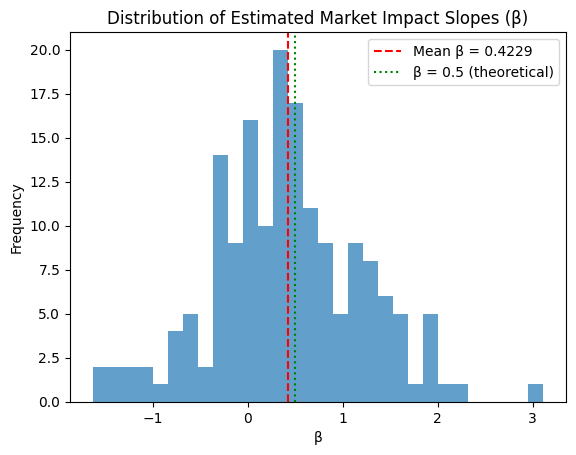

In [18]:
betas = calculate_betas_across_samples(b_dict, m_dict, all_series, x)


import matplotlib.pyplot as plt

# Построить распределение
plt.hist(betas, bins=30, alpha=0.7)
plt.axvline(np.mean(betas), color='red', linestyle='--', label=f"Mean β = {np.mean(betas):.4f}")
plt.axvline(0.5, color='green', linestyle=':', label="β = 0.5 (theoretical)")
plt.title("Distribution of Estimated Market Impact Slopes (β)")
plt.xlabel("β")
plt.ylabel("Frequency")
plt.legend()
plt.show()